In [18]:
import imp
import os
import tensorflow as tf
import tensorflow.keras as keras
import numpy as np
import glob
import cv2
import PIL
import matplotlib.pyplot as plt
from pyMLaux.functions import evaluate_classification_result, plot_history

# Kaggle Rome dataset base line: ResNet50 base weights
Check for GPU

In [19]:
tf.get_logger().setLevel('ERROR')

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
    raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


Basic constants

In [20]:
data_dir = "./../data/kaggle-rome-weather-dataset-resized"
batch_size = 16
number_images = 50
image_height = 224
image_width = 224
nr_color_channels = 3
seed = 2023

Create ImageDataGenerator for data augmentation of training data

In [21]:
datagen = keras.preprocessing.image.ImageDataGenerator(rescale=(1. / 255),
                                   shear_range=0.1,
                                   zoom_range=0.1,
                                   rotation_range=10,
                                   horizontal_flip=True,
                                   fill_mode='constant',
                                   preprocessing_function=keras.applications.resnet50.preprocess_input,
                                   validation_split= 0.2,
                                   cval=0)

Get training data

In [22]:
img_train = datagen.flow_from_directory(data_dir, target_size=(image_width,image_height), 
                                                    batch_size=batch_size,  subset='training', seed=seed,
                                                    class_mode='categorical')
img_train

Found 200 images belonging to 5 classes.


Get test data

In [23]:
img_test = datagen.flow_from_directory(data_dir, target_size=(image_width,image_height), 
                                                    batch_size=batch_size,  subset='validation', seed=seed,
                                                    class_mode='categorical')
img_test

Found 50 images belonging to 5 classes.


Load ResNet50

(approach taken from: https://medium.com/@kenneth.ca95/a-guide-to-transfer-learning-with-keras-using-resnet50-a81a4a28084b)

In [24]:
input_tensor = keras.Input(shape=(image_height,image_width,nr_color_channels))
resnet50_model = keras.applications.ResNet50(include_top=False,weights="imagenet",input_tensor=input_tensor)

Freeze layers apart from last block 

In [25]:
for layer in resnet50_model.layers[:134]:
    layer.trainable = False

Add new layers

In [26]:
model = keras.models.Sequential()
model.add(resnet50_model)
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(5,activation='softmax'))

Create model checkpoints

In [27]:
filepath = "./" + 'models/rome_resnet_base/rome_resnet_base_{epoch:02d}-{val_accuracy:.4f}.hdf5'
check_point = tf.keras.callbacks.ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1,
                                                save_best_only=True, mode='max')

In [28]:
callbacks_list = [check_point]

In [29]:
model.compile(loss='categorical_crossentropy',
                  optimizer=keras.optimizers.RMSprop(learning_rate=2e-5),
                  metrics=['accuracy'])

In [30]:
history = model.fit(img_train,
                    steps_per_epoch=(len(img_train.filenames) // batch_size), 
                    epochs=25,
                    validation_data=img_test, 
                    validation_steps=(len(img_test.filenames) // batch_size),
                    callbacks=callbacks_list)

Epoch 1/25
12/12 [==============================] - 9s 267ms/step - loss: 3.1191 - accuracy: 0.3152 - val_loss: 1.9645 - val_accuracy: 0.2083

Epoch 00001: val_accuracy improved from -inf to 0.20833, saving model to ./models/rome_resnet_base\rome_resnet_base_01-0.2083.hdf5


c:\Users\selin\miniconda3\envs\cov-project\lib\site-packages\tensorflow\python\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 2/25
12/12 [==============================] - 4s 298ms/step - loss: 1.8247 - accuracy: 0.4402 - val_loss: 2.0544 - val_accuracy: 0.2083

Epoch 00002: val_accuracy did not improve from 0.20833
Epoch 3/25
12/12 [==============================] - 4s 312ms/step - loss: 1.5147 - accuracy: 0.4837 - val_loss: 1.9830 - val_accuracy: 0.1458

Epoch 00003: val_accuracy did not improve from 0.20833
Epoch 4/25
12/12 [==============================] - 4s 305ms/step - loss: 1.2695 - accuracy: 0.5815 - val_loss: 2.0162 - val_accuracy: 0.2708

Epoch 00004: val_accuracy improved from 0.20833 to 0.27083, saving model to ./models/rome_resnet_base\rome_resnet_base_04-0.2708.hdf5
Epoch 5/25
12/12 [==============================] - 2s 195ms/step - loss: 1.4850 - accuracy: 0.5543 - val_loss: 2.0342 - val_accuracy: 0.2083

Epoch 00005: val_accuracy did not improve from 0.27083
Epoch 6/25
12/12 [==============================] - 2s 178ms/step - loss: 1.3068 - accuracy: 0.5489 - val_loss: 1.8928 - val_accu

Evaluate model

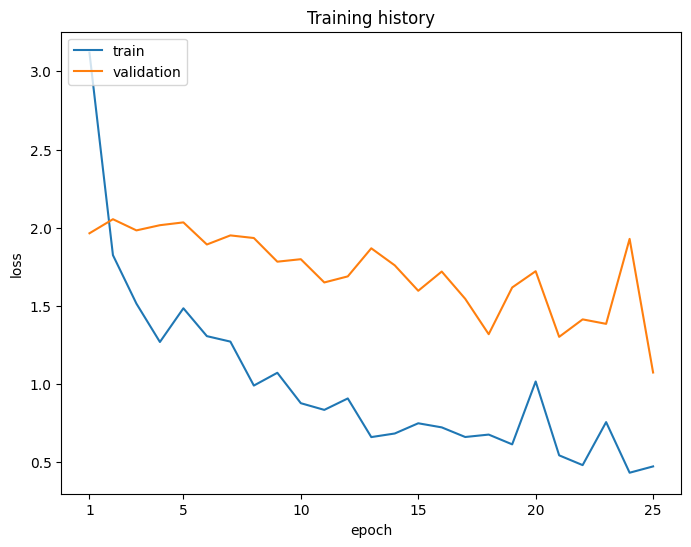

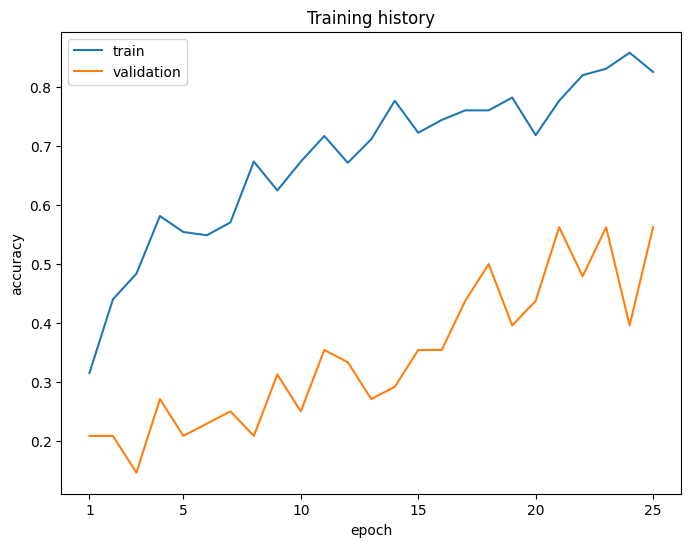

In [31]:
plot_history(history)

In [33]:
model = keras.models.load_model("./models/rome_resnet_base/rome_resnet_base_21-0.5625.hdf5")
pred = model.predict(img_test, steps=len(img_test.filenames))

In [34]:
evaluate_classification_result(img_test.classes, pred,classes=["foggy","cloudy","sunny","snowy","rainy"])

[[2 2 1 4 1]
 [1 3 0 4 2]
 [3 2 1 1 3]
 [1 2 1 5 1]
 [3 2 1 3 1]]


Class foggy:
    Sensitivity (TPR):  20.000% (2 of 10)
    Specificity (TNR):  80.000% (32 of 40)
    Precision:          20.000% (2 of 10)
    Neg. pred. value:   80.000% (32 of 40)
Class cloudy:
    Sensitivity (TPR):  30.000% (3 of 10)
    Specificity (TNR):  80.000% (32 of 40)
    Precision:          27.273% (3 of 11)
    Neg. pred. value:   82.051% (32 of 39)
Class sunny:
    Sensitivity (TPR):  10.000% (1 of 10)
    Specificity (TNR):  92.500% (37 of 40)
    Precision:          25.000% (1 of 4)
    Neg. pred. value:   80.435% (37 of 46)
Class snowy:
    Sensitivity (TPR):  50.000% (5 of 10)
    Specificity (TNR):  70.000% (28 of 40)
    Precision:          29.412% (5 of 17)
    Neg. pred. value:   84.848% (28 of 33)
Class rainy:
    Sensitivity (TPR):  10.000% (1 of 10)
    Specificity (TNR):  82.500% (33 of 40)
    Precision:          12.500% (1 of 8)
    Neg. pred. value:   78.571% (33 of 42)

Overall accuracy:

array([[2, 2, 1, 4, 1],
       [1, 3, 0, 4, 2],
       [3, 2, 1, 1, 3],
       [1, 2, 1, 5, 1],
       [3, 2, 1, 3, 1]], dtype=int64)